# Creating an Interactive Dashboard using `hvPlot` and `Panel`

---

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
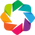

In [15]:
import holoviews as hv
import hvplot.xarray
import panel as pn
import xarray as xr
from holoviews import opts

hv.extension("bokeh")

## Data

In [16]:
rda_url = "https://data.rda.ucar.edu/"
annual_means = rda_url + "pythia_era5_24/annual_means/"
xrds = xr.open_dataset(annual_means + "temp_2m_annual_1940_2023.zarr", engine="zarr")
xrds = xrds.isel(time=slice(0, 5))
xrds.load()

<xarray.Dataset>
Dimensions:    (time: 5, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-12-31 1941-12-31 ... 1944-12-31
Data variables:
    VAR_2T     (time, latitude, longitude) float32 258.2 258.2 ... 226.1 226.1

## Dataset Widgets

In [23]:
w_var = pn.widgets.Select(name="Data Variable", options=list(xrds.data_vars))

dataset_controls = pn.WidgetBox(
    "## Dataset Controls",
    w_var,
)
dataset_controls

WidgetBox
    [0] Markdown(str)
    [1] Select(name='Data Variable', options=['VAR_2T'], value='VAR_2T')

## Plotting Widgets

In [24]:
w_cmap = pn.widgets.Select(name="Colormap", options=["inferno", "plasma", "coolwarm"])


w_plot_type = pn.widgets.Select(
    name="Plot Type", options=["Color Plot", "Contour", "Filled Contour"]
)


plot_controls = pn.WidgetBox(
    "## Plot Controls",
    w_plot_type,
    w_cmap,
)
plot_controls

WidgetBox
    [0] Markdown(str)
    [1] Select(name='Plot Type', options=['Color Plot', ...], value='Color Plot')
    [2] Select(name='Colormap', options=['inferno', 'plasma', ...], value='inferno')

## Animation Widgets

In [31]:
w_player = pn.widgets.Player(
    value=0,
    start=0,
    end=len(xrds.time) - 1,
    name="Year",
    loop_policy="loop",
    interval=300,
    align="center",
    width_policy="fit",
)
w_player

Player(align='center', end=4, interval=300, loop_policy='loop', name='Year', width_policy='fit')

## Plotting Function

In [32]:
def plot_ds(time, var, cmap, plot_type):
    clim = (xrds[var].values.min(), xrds[var].values.max())

    if plot_type == "Color Plot":
        return (
            xrds[var]
            .isel(time=time)
            .hvplot(
                cmap=cmap,
                title=str(f"{var} year {time}"),
                clim=clim,
                dynamic=False,
                rasterize=True,
                precompute=True,
            )
            .opts(framewise=False)
        )

    elif plot_type == "Contour":
        return (
            xrds[var]
            .isel(time=time)
            .hvplot.contour(
                cmap=cmap,
                dynamic=False,
                rasterize=True,
                title=str(f"{var} Year: {time}"),
                clim=clim,
                precompute=True,
            )
            .opts(framewise=False)
        )
    elif plot_type == "Filled Contour":
        return (
            xrds[var]
            .isel(time=time)
            .hvplot.contourf(
                cmap=cmap,
                dynamic=False,
                rasterize=True,
                title=str(f"{var} Year: {time}"),
                clim=(200, 300),
                precompute=True,
            )
            .opts(framewise=False)
        )

## Putting it all Together

In [33]:
controls = pn.Column(dataset_controls, plot_controls)

app = pn.Row(
    controls,
    pn.Column(
        pn.panel(
            hv.DynamicMap(
                pn.bind(
                    plot_ds,
                    time=w_player,
                    var=w_var,
                    cmap=w_cmap,
                    plot_type=w_plot_type,
                )
            )
        ),
        w_player,
    ),
)

app

Row
    [0] Column
        [0] WidgetBox
            [0] Markdown(str)
            [1] Select(name='Data Variable', options=['VAR_2T'], value='VAR_2T')
        [1] WidgetBox
            [0] Markdown(str)
            [1] Select(name='Plot Type', options=['Color Plot', ...], value='Color Plot')
            [2] Select(name='Colormap', options=['inferno', 'plasma', ...], value='inferno')
    [1] Column
        [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=700)
        [1] Player(align='center', end=4, interval=300, loop_policy='loop', name='Year', width_policy='fit')